\newpage

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import cross_val_score
from boruta import boruta_py
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

### 1. Classification Problem Identification:

Based on the dataset, the classification problem is to predict whether a certain patient will have chronic kidney disease (CKD) or not. The dataset contains variables which will help in achieving this goal.

### 2. Variable Transformation:

In [69]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
chronic_kidney_disease = fetch_ucirepo(id=336) 
  
# data (as pandas dataframes) 
X = chronic_kidney_disease.data.features 
y = chronic_kidney_disease.data.targets
data = pd.concat([X, y], axis = 1)
pd.set_option('display.max_columns', None)
print(data.head(10))

    age     bp     sg   al   su       rbc        pc         pcc          ba  \
0  48.0   80.0  1.020  1.0  0.0       NaN    normal  notpresent  notpresent   
1   7.0   50.0  1.020  4.0  0.0       NaN    normal  notpresent  notpresent   
2  62.0   80.0  1.010  2.0  3.0    normal    normal  notpresent  notpresent   
3  48.0   70.0  1.005  4.0  0.0    normal  abnormal     present  notpresent   
4  51.0   80.0  1.010  2.0  0.0    normal    normal  notpresent  notpresent   
5  60.0   90.0  1.015  3.0  0.0       NaN       NaN  notpresent  notpresent   
6  68.0   70.0  1.010  0.0  0.0       NaN    normal  notpresent  notpresent   
7  24.0    NaN  1.015  2.0  4.0    normal  abnormal  notpresent  notpresent   
8  52.0  100.0  1.015  3.0  0.0    normal  abnormal     present  notpresent   
9  53.0   90.0  1.020  2.0  0.0  abnormal  abnormal     present  notpresent   

     bgr     bu    sc    sod  pot  hemo   pcv     wbcc  rbcc  htn   dm cad  \
0  121.0   36.0   1.2    NaN  NaN  15.4  44.0   7800

In [70]:
# variable information 
print(chronic_kidney_disease.variables)

     name     role         type demographic              description  \
0     age  Feature      Integer         Age                     None   
1      bp  Feature      Integer        None           blood pressure   
2      sg  Feature  Categorical        None         specific gravity   
3      al  Feature  Categorical        None                  albumin   
4      su  Feature  Categorical        None                    sugar   
5     rbc  Feature       Binary        None          red blood cells   
6      pc  Feature       Binary        None                 pus cell   
7     pcc  Feature       Binary        None          pus cell clumps   
8      ba  Feature       Binary        None                 bacteria   
9     bgr  Feature      Integer        None     blood glucose random   
10     bu  Feature      Integer        None               blood urea   
11     sc  Feature   Continuous        None         serum creatinine   
12    sod  Feature      Integer        None                   so

In [71]:
#print unique values in categorical columns
cols_bin = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
cols_categ = ['sg', 'al', 'su']
for col in cols_bin + cols_categ:
    print(col, data[col].unique())
    
#fix typo in "dm"
X.loc[X['dm'] == '\tno', 'dm'] = 'no'

data_feat_clean_nom = X.astype({col: 'category' for col in cols_bin + cols_categ})

for col in cols_bin + cols_categ:
    data_feat_clean_nom[col] = data_feat_clean_nom[col].cat.codes.astype('Int64')

data_feat_clean_nom[data_feat_clean_nom.loc[:, cols_bin + cols_categ] == -1] = None

rbc [nan 'normal' 'abnormal']
pc ['normal' 'abnormal' nan]
pcc ['notpresent' 'present' nan]
ba ['notpresent' 'present' nan]
htn ['yes' 'no' nan]
dm ['yes' 'no' '\tno' nan]
cad ['no' 'yes' nan]
appet ['good' 'poor' nan]
pe ['no' 'yes' nan]
ane ['no' 'yes' nan]
sg [1.02  1.01  1.005 1.015   nan 1.025]
al [ 1.  4.  2.  3.  0. nan  5.]
su [ 0.  3.  4.  1. nan  2.  5.]


In [72]:
for var in cols_bin:
    print(var, set(zip(data_feat_clean_nom[var], X[var])))

rbc {(<NA>, nan), (0, 'abnormal'), (1, 'normal')}
pc {(<NA>, nan), (0, 'abnormal'), (1, 'normal')}
pcc {(<NA>, nan), (0, 'notpresent'), (1, 'present')}
ba {(<NA>, nan), (0, 'notpresent'), (1, 'present')}
htn {(1, 'yes'), (<NA>, nan), (0, 'no')}
dm {(1, 'yes'), (<NA>, nan), (0, 'no')}
cad {(1, 'yes'), (<NA>, nan), (0, 'no')}
appet {(<NA>, nan), (0, 'good'), (1, 'poor')}
pe {(1, 'yes'), (<NA>, nan), (0, 'no')}
ane {(1, 'yes'), (<NA>, nan), (0, 'no')}


In [73]:
for var in cols_categ:
    categ_pairs = zip(data_feat_clean_nom[var], X[var])
    print(var, set((ftr_cln, ft) for ftr_cln, ft in categ_pairs if ft in X[var].unique()))

sg {(2, 1.015), (3, 1.02), (0, 1.005), (4, 1.025), (1, 1.01)}
al {(4, 4.0), (5, 5.0), (0, 0.0), (1, 1.0), (3, 3.0), (2, 2.0)}
su {(4, 4.0), (5, 5.0), (0, 0.0), (1, 1.0), (3, 3.0), (2, 2.0)}


In [74]:
# fix typo in "class" and ignore error
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore')
    y.loc[y.loc[:, 'class'] == 'ckd\t', 'class'] = 'ckd'

data_targ_clean = y.astype({'class': 'category'})
data_targ_clean['class'] = data_targ_clean['class'].cat.codes.astype('Int64')

data_targ_clean[data_targ_clean.loc[:, 'class'] == -1] = None

print('class', set(zip(data_targ_clean['class'], y['class'])))

class {(1, 'notckd'), (0, 'ckd')}


In [75]:
#standardize numerical variables
cols_cts = ['sc', 'pot', 'hemo', 'rbcc']

cts_scaler = StandardScaler().fit(data_feat_clean_nom[cols_cts])
data_feat_clean_nom[cols_cts] = cts_scaler.transform(data_feat_clean_nom[cols_cts])

cols_int = list(set(data_feat_clean_nom).difference(set(cols_bin + cols_categ + cols_cts)))

# fix data dictionary violation (`Integer`) for "sod" and "bu
data_feat_clean_nom.loc[data_feat_clean_nom['sod'] == 4.5, 'sod'] = 5
data_feat_clean_nom.loc[data_feat_clean_nom['bu'] == 50.1, 'bu'] = 50
data_feat_clean_nom.loc[data_feat_clean_nom['bu'] == 1.5, 'bu'] = 2
data_feat_clean_nom.loc[data_feat_clean_nom['bu'] == 98.6, 'bu'] = 99

data_feat_clean = data_feat_clean_nom.astype({col: 'Int64' for col in cols_int})

int_scaler = StandardScaler().fit(data_feat_clean_nom[cols_int])
data_feat_clean[cols_int] = int_scaler.transform(data_feat_clean_nom[cols_int])

data_feat_clean.dtypes

age      float64
bp       float64
sg         Int64
al         Int64
su         Int64
rbc        Int64
pc         Int64
pcc        Int64
ba         Int64
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn        Int64
dm         Int64
cad        Int64
appet      Int64
pe         Int64
ane        Int64
dtype: object

### 3. Dataset Overview:

- The summary statistics and data distributions for the original dataset display details of only a certain number of variables, which were of the float type, as the others are of the object datatype.
- The dataset has 25 variables (24 features and 1 target) and 400 observations in total. After the transformation, it now contains float and integer variables.
- Analysis of the summary statistics shows that the counts for each variable are different, indicating the presence of missing values, which will be dealt in the next question.
- Based on the summary statistics, the average age of individuals is 51.483376, ranging from 2 to 90 years old.
- The bg variable, representing blood glucose random has a high standard deviation of 79.28, indicating a significant amount of variability in the blood glucose values of individuals.
- After transformation and cleaning, the categorical columns in the dataset contain binary or numerical values, and do not contain errors (typos) like before.

In [76]:
#variables
data_clean = pd.concat([data_feat_clean, data_targ_clean], axis = 1)
variables = data_clean.columns.tolist()
print("Variables:", variables)

Variables: ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']


In [77]:
#summaries of the original dataset
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
              age          bp          sg          al          su         bgr  \
count  391.000000  388.000000  353.000000  354.000000  351.000000  356.000000   
mean    51.483376   76.469072    1.017408    1.016949    0.450142  148.036517   
std     17.169714   13.683637    0.005717    1.352679    1.099191   79.281714   
min      2.000000   50.000000    1.005000    0.000000    0.000000   22.000000   
25%     42.000000   70.000000    1.010000    0.000000    0.000000   99.000000   
50%     55.000000   80.000000    1.020000    0.000000    0.000000  121.000000   
75%     64.500000   80.000000    1.020000    2.000000    0.000000  163.000000   
max     90.000000  180.000000    1.025000    5.000000    5.000000  490.000000   

               bu          sc         sod         pot        hemo         pcv  \
count  381.000000  383.000000  313.000000  312.000000  348.000000  329.000000   
mean    57.425722    3.072454  137.528754    4.627244   12.526437   38.884498   
std   

In [78]:
#observation counts
print("\nObservation Counts:")
print(data.count())


Observation Counts:
age      391
bp       388
sg       353
al       354
su       351
rbc      248
pc       335
pcc      396
ba       396
bgr      356
bu       381
sc       383
sod      313
pot      312
hemo     348
pcv      329
wbcc     294
rbcc     269
htn      398
dm       398
cad      398
appet    399
pe       399
ane      399
class    400
dtype: int64


In [79]:
#data types
print("\nData Types before transformation:")
print(data.dtypes)
print("\nData Types after transformation:")
print(data_clean.dtypes)


Data Types before transformation:
age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

Data Types after transformation:
age      float64
bp       float64
sg         Int64
al         Int64
su         Int64
rbc        Int64
pc         Int64
pcc        Int64
ba         Int64
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn        Int64
dm         Int64
cad        Int64
appet      Int64
pe         Int64
ane        Int64
class      Int64
dtype: object



Distributions before transformation:
[[<Axes: title={'center': 'age'}> <Axes: title={'center': 'bp'}>
  <Axes: title={'center': 'sg'}> <Axes: title={'center': 'al'}>]
 [<Axes: title={'center': 'su'}> <Axes: title={'center': 'bgr'}>
  <Axes: title={'center': 'bu'}> <Axes: title={'center': 'sc'}>]
 [<Axes: title={'center': 'sod'}> <Axes: title={'center': 'pot'}>
  <Axes: title={'center': 'hemo'}> <Axes: title={'center': 'pcv'}>]
 [<Axes: title={'center': 'wbcc'}> <Axes: title={'center': 'rbcc'}>
  <Axes: > <Axes: >]]


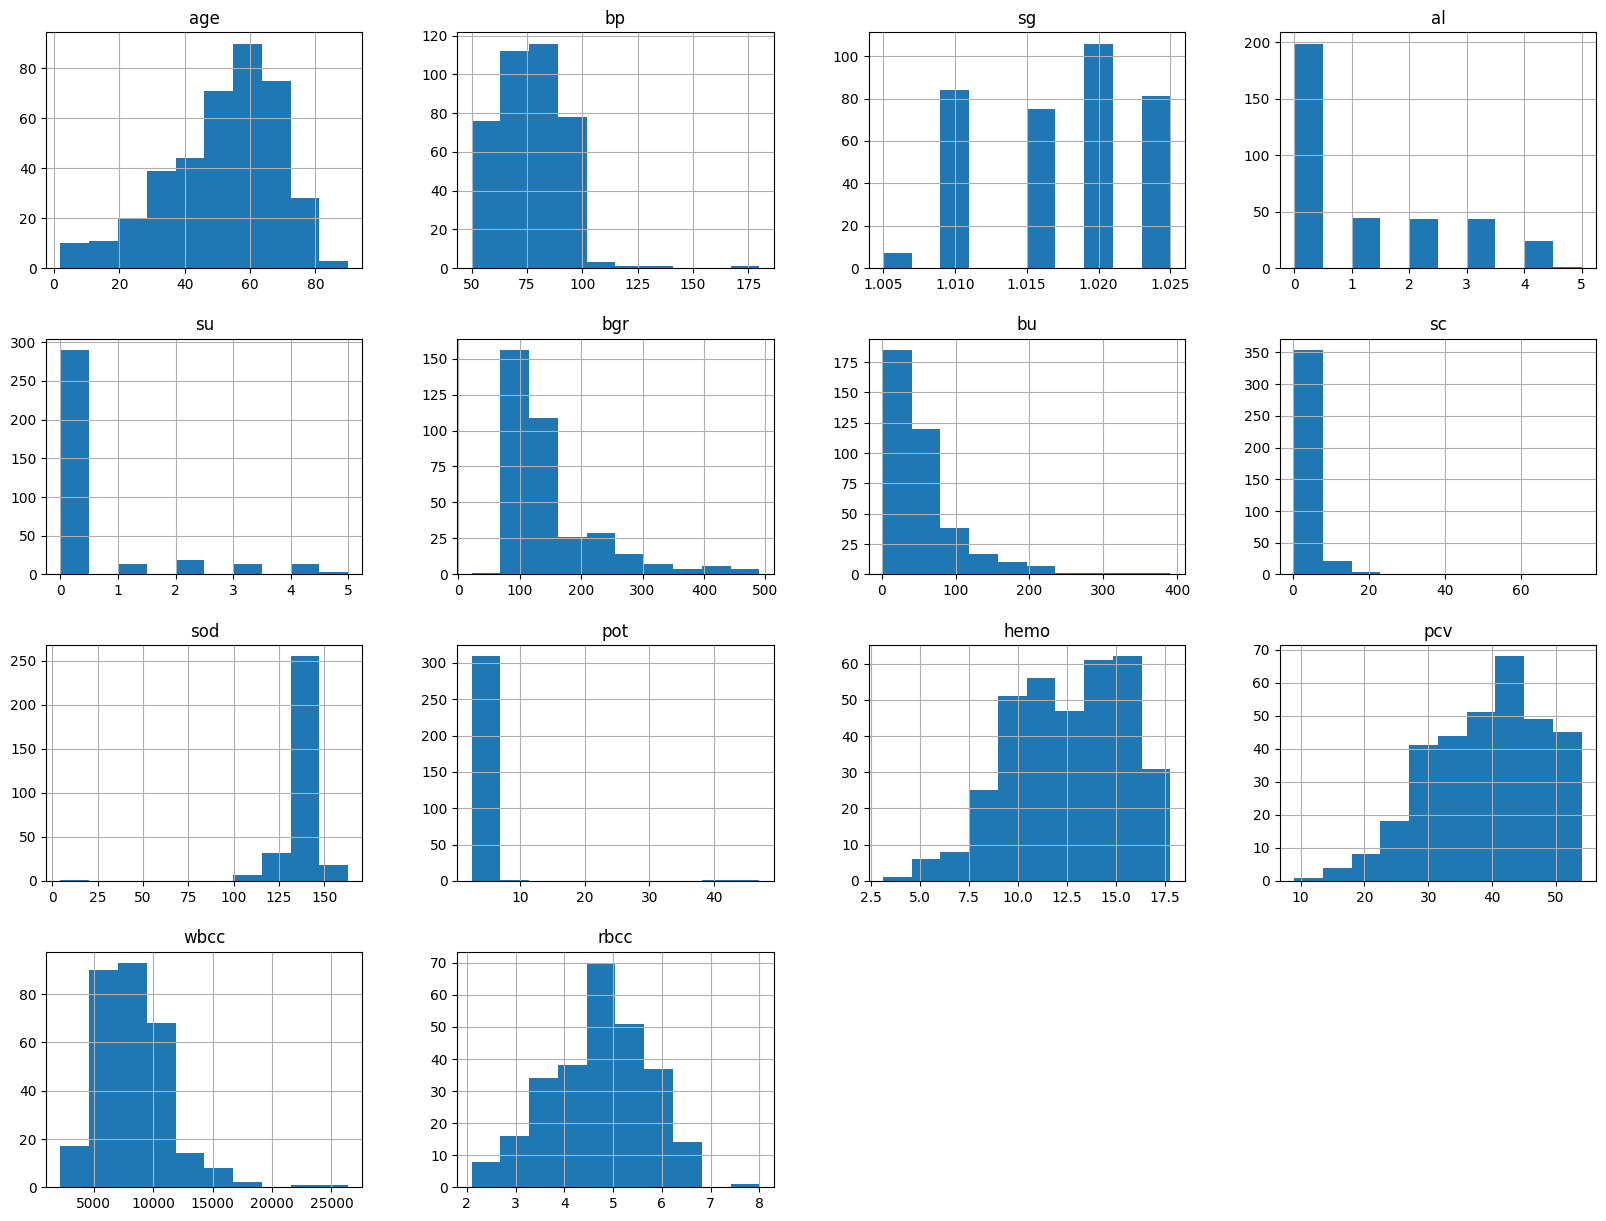

In [80]:
#distributions
print("\nDistributions before transformation:")
print(data.hist(figsize=(20, 15)))


Distributions after transformation:
[[<Axes: title={'center': 'age'}> <Axes: title={'center': 'bp'}>
  <Axes: title={'center': 'sg'}> <Axes: title={'center': 'al'}>
  <Axes: title={'center': 'su'}>]
 [<Axes: title={'center': 'rbc'}> <Axes: title={'center': 'pc'}>
  <Axes: title={'center': 'pcc'}> <Axes: title={'center': 'ba'}>
  <Axes: title={'center': 'bgr'}>]
 [<Axes: title={'center': 'bu'}> <Axes: title={'center': 'sc'}>
  <Axes: title={'center': 'sod'}> <Axes: title={'center': 'pot'}>
  <Axes: title={'center': 'hemo'}>]
 [<Axes: title={'center': 'pcv'}> <Axes: title={'center': 'wbcc'}>
  <Axes: title={'center': 'rbcc'}> <Axes: title={'center': 'htn'}>
  <Axes: title={'center': 'dm'}>]
 [<Axes: title={'center': 'cad'}> <Axes: title={'center': 'appet'}>
  <Axes: title={'center': 'pe'}> <Axes: title={'center': 'ane'}>
  <Axes: title={'center': 'class'}>]]


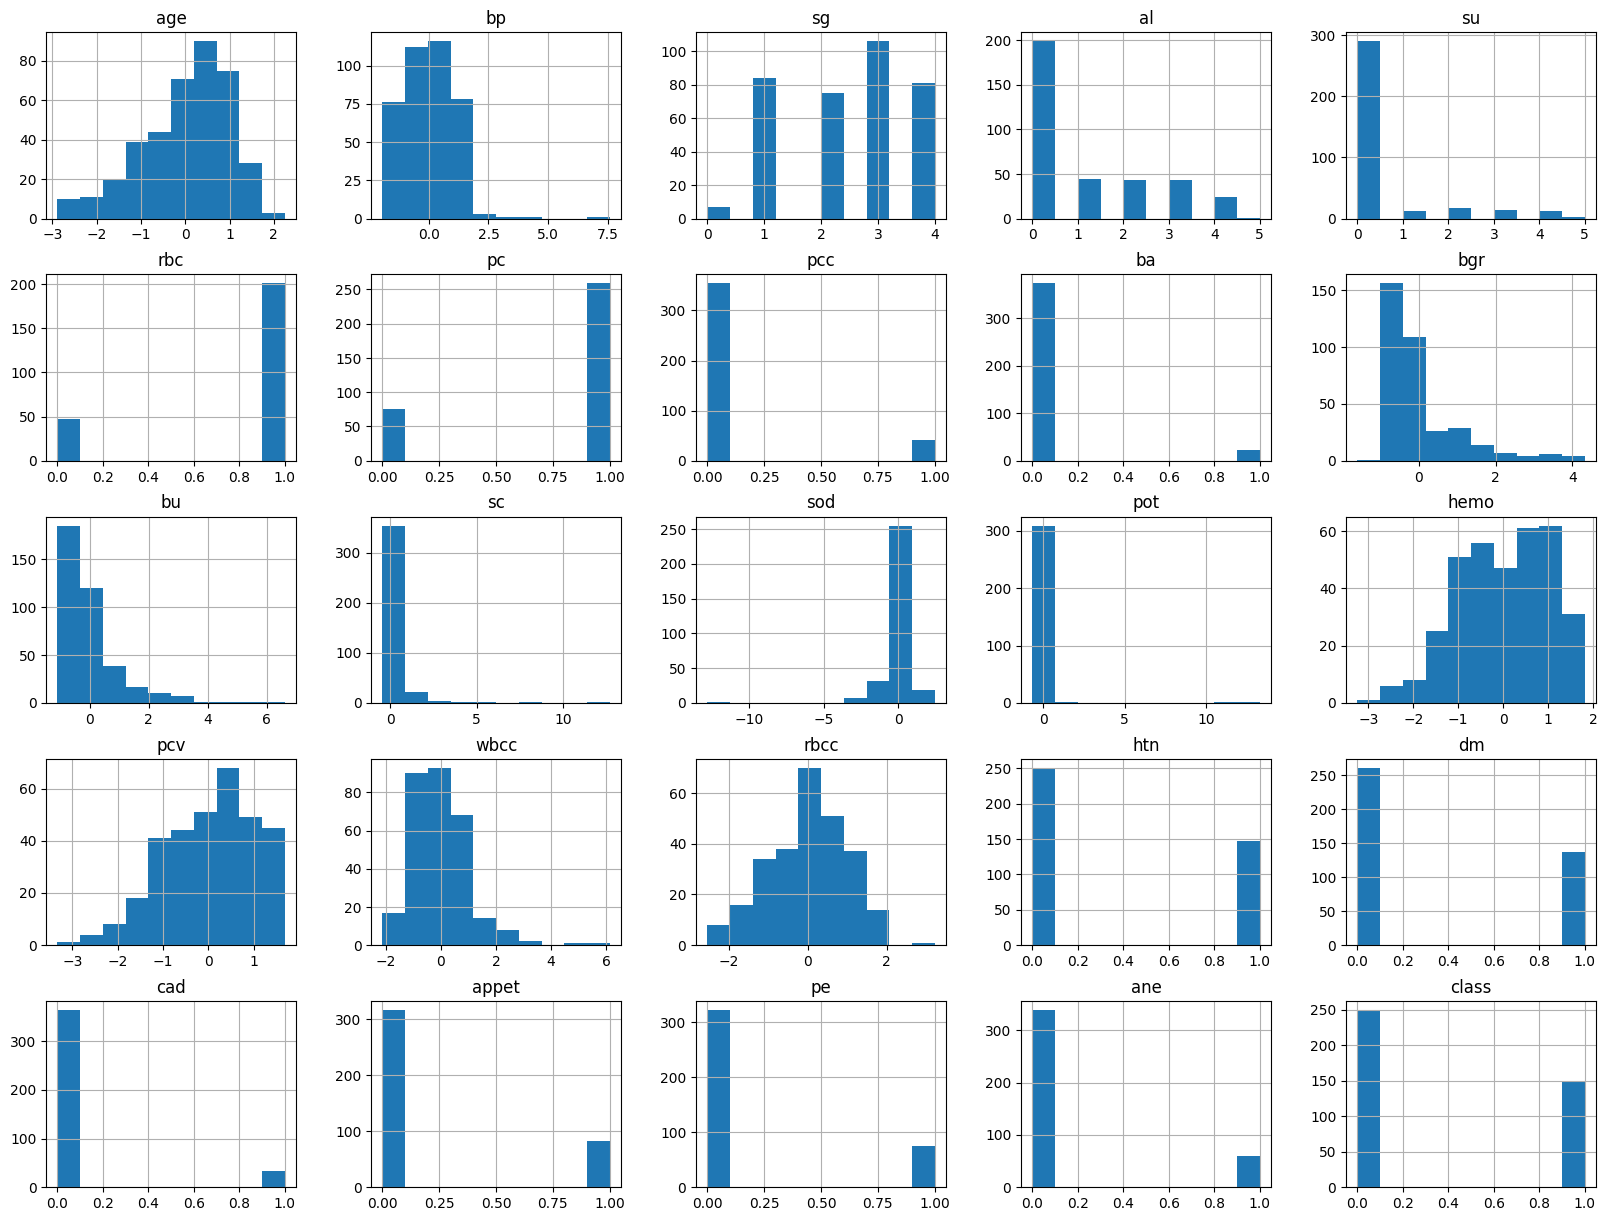

In [81]:
print("\nDistributions after transformation:")
print(data_clean.hist(figsize=(20, 15)))

In [82]:
#categorical variables post transformation
#note that sg, al and au are nominal variables, as per the data dictionary, hence they were converted
for col in cols_bin + cols_categ:
    print(col, data_clean[col].unique())

rbc <IntegerArray>
[<NA>, 1, 0]
Length: 3, dtype: Int64
pc <IntegerArray>
[1, 0, <NA>]
Length: 3, dtype: Int64
pcc <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
ba <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
htn <IntegerArray>
[1, 0, <NA>]
Length: 3, dtype: Int64
dm <IntegerArray>
[1, 0, <NA>]
Length: 3, dtype: Int64
cad <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
appet <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
pe <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
ane <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
sg <IntegerArray>
[3, 1, 0, 2, <NA>, 4]
Length: 6, dtype: Int64
al <IntegerArray>
[1, 4, 2, 3, 0, <NA>, 5]
Length: 7, dtype: Int64
su <IntegerArray>
[0, 3, 4, 1, <NA>, 2, 5]
Length: 7, dtype: Int64


### 4. Association Between Variables:

- The heatmap gives paiwise correlations between all variables in the dataframe, with regions of darker red or blue indicating stronger correlation between the variables. For example, there appears to be a strong correlation between hemoglobin and red blood cells count (0.80), which also makes sense intuitively.
- The correlation between diabetes and sugar (0.52), and diabetes and glucouse levels (0.53), is also quite strong, implying that if an individual has diabetes, it is likely that their blood sugar level as well as glucose levels are high (and vice versa), which is natural.
- Moreover, the variable representing sugar is positively correlated to the variable representing blood glucose. This also makes sense as diabetes is commonly associated with kidney disease.

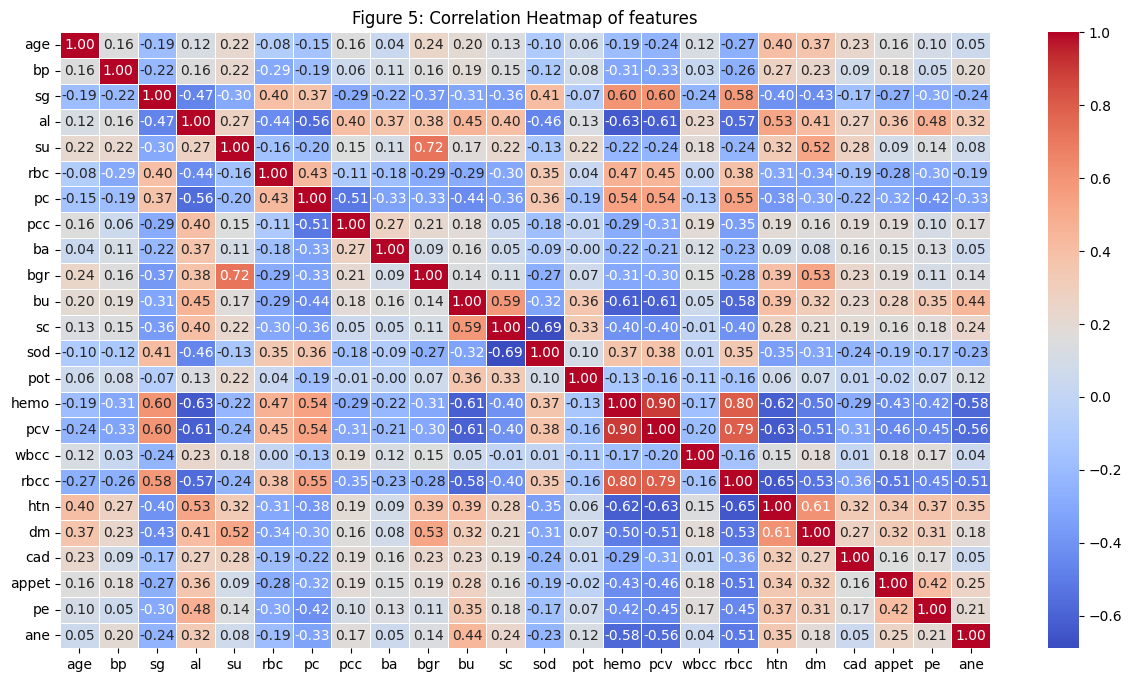

In [83]:
plt.figure(figsize = (15,8))
sns.heatmap(data_feat_clean.corr(), annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths=.5)
plt.title('Figure 5: Correlation Heatmap of features')
plt.show()

### 5. Missing Value Analysis and Handling:

In [84]:
print(data_feat_clean.isnull().sum())
print(data_feat_clean.shape)

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64
(400, 24)


Misisng values cannot be removed altogether, as that would lead to an even smaller dataset, which is not ideal for making predictions. Hence, we must impute the missing values.

In [85]:
imputer = KNNImputer(n_neighbors = 5)
knn_imputed = imputer.fit_transform(data_feat_clean)
knn_imputed

array([[-0.20313902,  0.25837332,  3.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.59412412, -1.93685691,  3.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61329491,  0.25837332,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-2.30254057,  0.25837332,  3.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.01095702, -1.2051135 ,  4.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38002807,  0.25837332,  4.        , ...,  0.        ,
         0.        ,  0.        ]])

In [86]:
mean_imputed = SimpleImputer(missing_values = np.nan, strategy = 'mean').fit_transform(data_feat_clean)
median_imputed = SimpleImputer(missing_values = np.nan, strategy = 'median').fit_transform(data_feat_clean)
mode_imputed = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent').fit_transform(data_feat_clean)
iter_imputed = IterativeImputer(random_state=0, max_iter=20).fit_transform(data_feat_clean)
filled = (knn_imputed + mean_imputed + median_imputed + mode_imputed + iter_imputed) / 5
filled

array([[-0.20313902,  0.25837332,  3.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.59412412, -1.93685691,  3.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61329491,  0.25837332,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-2.30254057,  0.25837332,  3.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.01095702, -1.2051135 ,  4.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38002807,  0.25837332,  4.        , ...,  0.        ,
         0.        ,  0.        ]])

In [87]:
np.sum(filled - knn_imputed) / (400 * 24)

0.006732167433913292

In [88]:
#all missing values have been imputed
np.count_nonzero(np.isnan(knn_imputed))

0

### 6. Outlier Analysis

Since this is a medical dataset, it may contain extreme cases which can be clinically significant. Removing these outliers can lead to loss of important information and hence inaccuracy. 

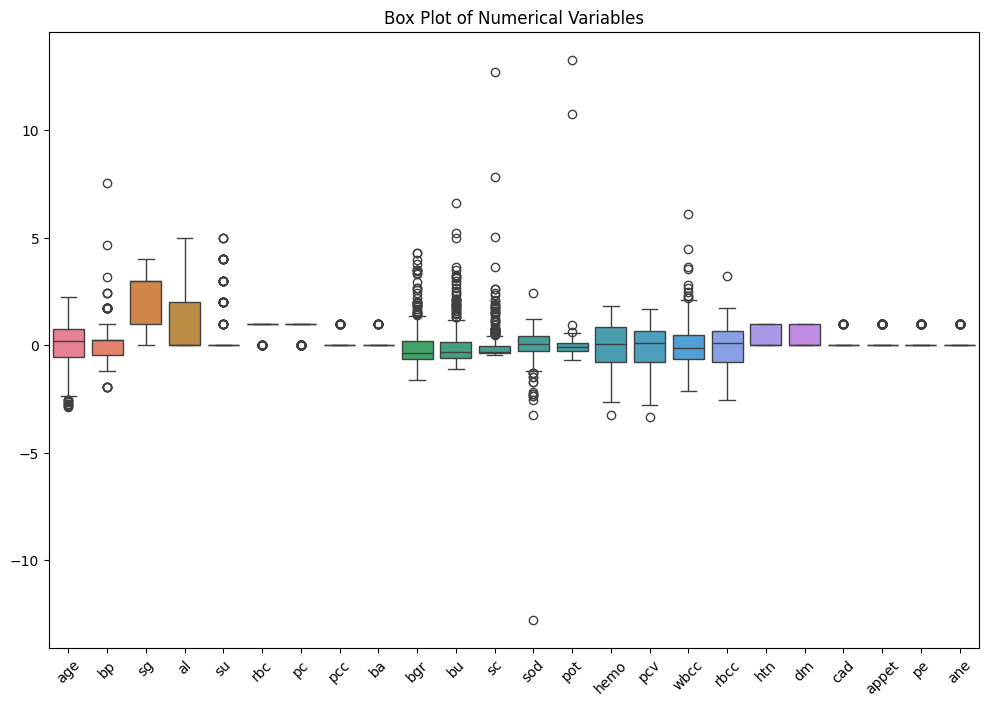

In [89]:
plt.figure(figsize = (12, 8))
sns.boxplot(data = data_feat_clean)
plt.xticks(rotation = 45)
plt.title('Box Plot of Numerical Variables')
plt.show()

### 7. Sub-group Analysis:

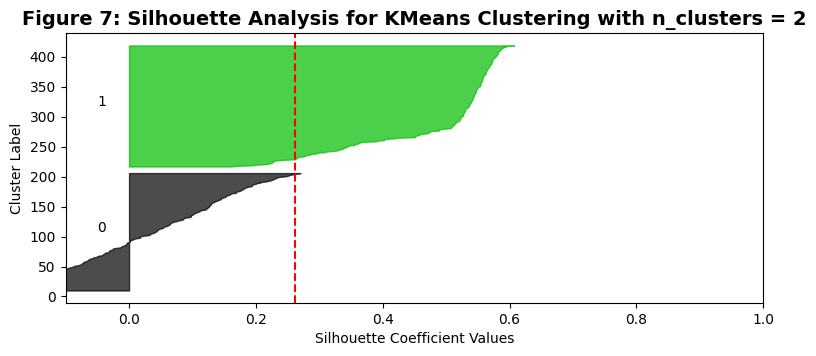

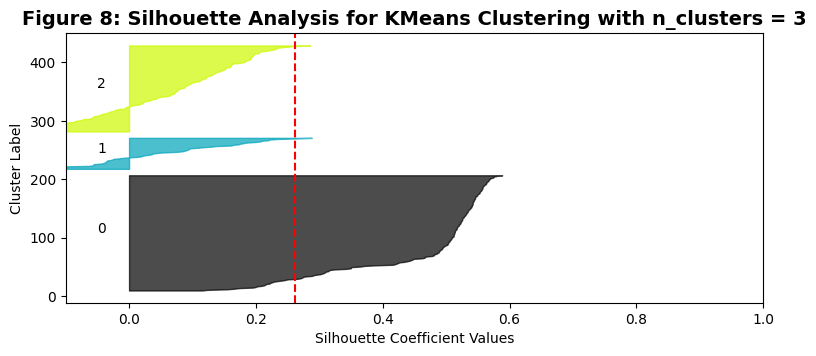

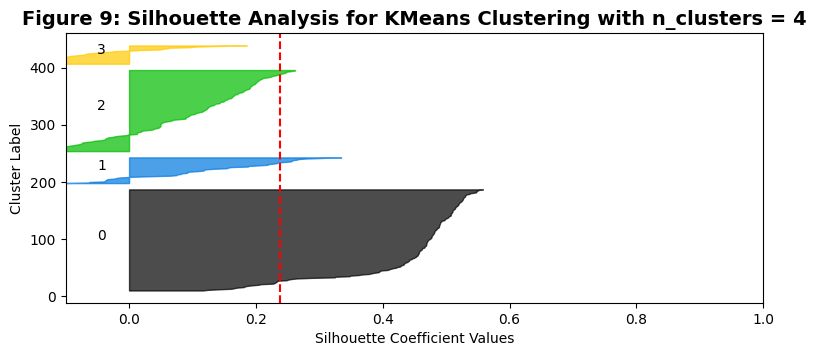

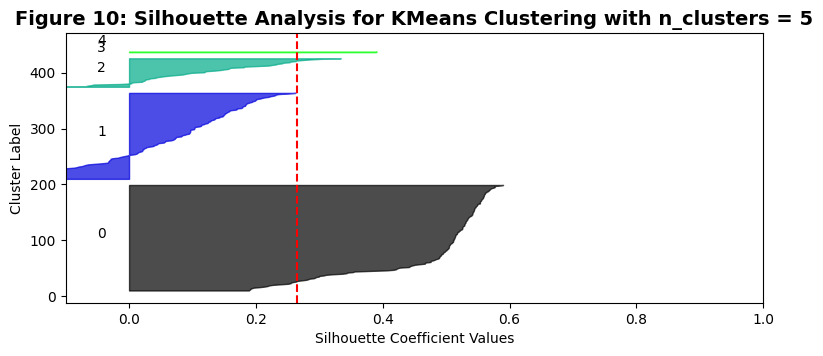

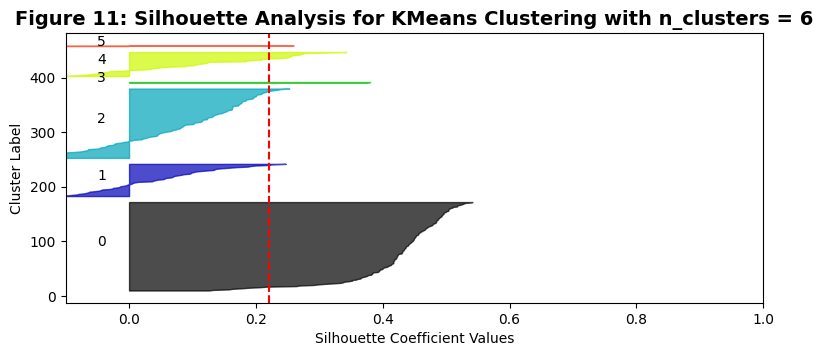

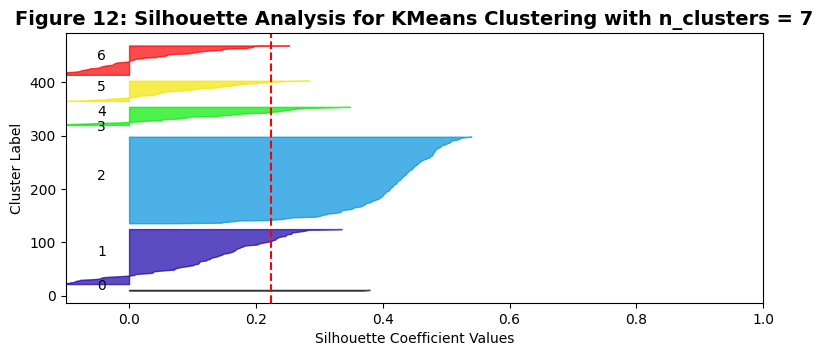

In [90]:
k_values = list(range(2,8))
silhouette_scores = []

for k in k_values:
    km = KMeans(n_clusters = k, n_init = 20, random_state=0)
    cluster_labels = km.fit_predict(filled)
    silhouette_avg_km = silhouette_score(filled, cluster_labels)

    silhouette_scores.append(silhouette_avg_km)

    sample_silhouette_values = silhouette_samples(filled, cluster_labels)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18/2, 7/2)
    ax1.set_xlim([-0.1, 1])

    y_lower = 10
    
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for various cluster")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_km, color="red", linestyle="--")
    plt.title(
        f"Figure {5+k}: Silhouette Analysis for KMeans Clustering with n_clusters = {k}",
        fontsize=14,
        fontweight="bold",
    )

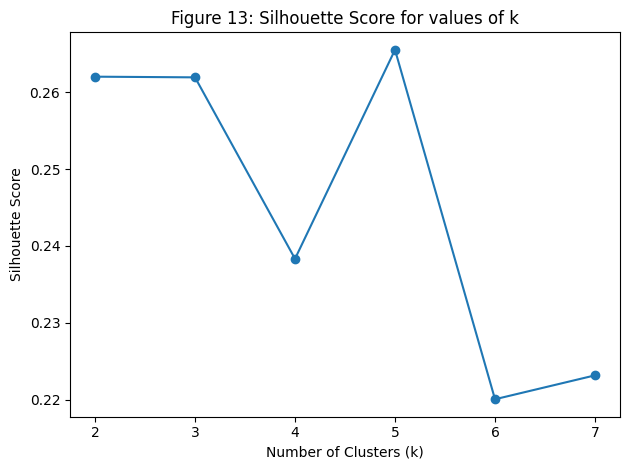

In [91]:
#silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Figure 13: Silhouette Score for values of k')
plt.tight_layout()
plt.show()

In [92]:
print(k_values[np.argmax(silhouette_scores)], ",", np.max(silhouette_scores))

5 , 0.26554064284841605


The optimal value for k is 5 with a silhouette score of 0.2655.

### 8. Data splitting:

In [93]:
np.random.seed(1) 
X_train, X_test, y_train, y_test = train_test_split (filled, data_targ_clean['class'], 
                                                     train_size = 0.7, test_size = 0.3, random_state = 0,
                                                     stratify = data_targ_clean['class'])

### 9. Classifier Choices:

## Random forest 
I am using this is classifier as it is quite popular for healthcare datasets. Moreover, it can handle a large number of variables and reduce overfitting. 

In [94]:
rf = RandomForestClassifier (n_estimators = 1000, criterion = 'gini')
rf.fit(X_train, y_train.values.ravel())
y_predrf = rf.predict(X_test)

## KNN
Since our data contains many outliers and KNN is relatively robust to outliers, it can help in reducing the influence of outliers on the predictions. It is also fairly easy to implement.

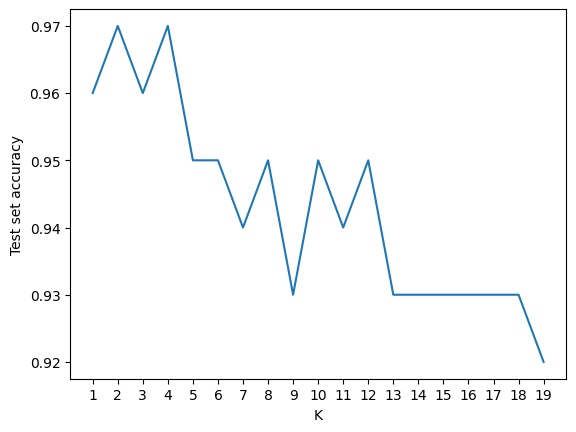

In [95]:
scores = []
krange = range(1, 20)
for k in krange:
    knn = KNeighborsClassifier (n_neighbors = k)
    knn.fit(X_train, y_train.values.ravel())
    y_pred = knn.predict(X_test)
    scores.append(round(metrics.accuracy_score(y_test, y_pred),2))
plt.plot(krange, scores)
plt.xlabel('K')
plt.ylabel('Test set accuracy')
plt.xticks(range(1, 20))
plt.show()

In [96]:
#let k = 4

knn4 = neighbors.KNeighborsClassifier(n_neighbors = 4, algorithm='brute')
knn4.fit(X_train, y_train)
pred4 = knn4.predict(X_test)

#accuracy
print(round(metrics.accuracy_score(y_test, pred4),2))
confusion_matrix = confusion_matrix(y_test, pred4)
confusion_matrix

0.97


array([[71,  4],
       [ 0, 45]])

### 10. Performance Metrics: 

- To compare the performance of the classifiers, cross validation score can be used for comparison. The sensitivity and specificity can help in gaining a better understanding of their performance. A confusion matrix can also be generated.
- AUC score can also be determined to evaluate the performance of the classifiers. 

### 11. Feature Selection/Extraction:
I will use Sequential Forward Selection which will enhance the performance of KNN by iteratively selecting the most relevant features from the dataset.

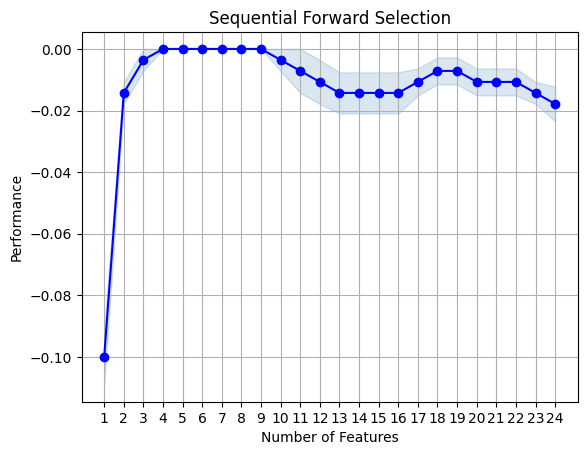

In [97]:
sfs = SFS(knn4, k_features = (1, 24), forward = True, floating = False, scoring = 'neg_mean_squared_error', cv = 5)
sfs = sfs.fit(X_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind = 'std_err')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

### 12. Classifier Comparison:

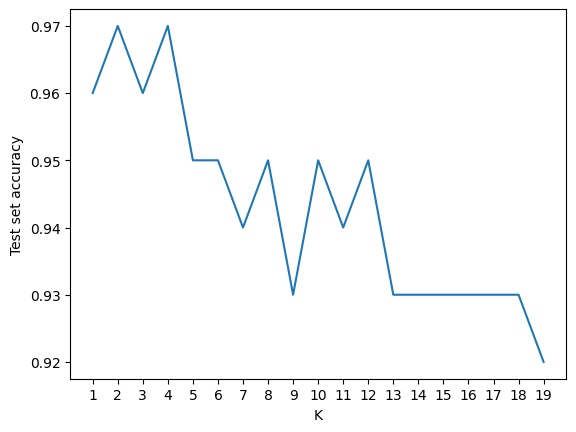

AUC for KNN 0.9733333333333333
AUC for Random Forest Classifier 0.9888888888888889


In [98]:
#random forest with accuracy score
"""
I will use Boruta for working on the Random Forest Classifier, which is a feature selection algorithm. It helps in identifying the most
important features by comparing their importance with that of random features.
"""
borutaf = RandomForestClassifier(n_jobs = -1)
data_feature_selector = boruta_py.BorutaPy(borutaf, max_iter = 20)
data_feature_selector.fit(X_train, y_train)
X_train_updated = data_feature_selector.transform(X_train) #includes only selected features
rfc = RandomForestClassifier(criterion = 'gini')
rfc.fit(X_train[:, data_feature_selector.support_], y_train.values.ravel()) #classifier fitted to the data with selected features
y_pred_rf = rfc.predict(X_test[:, data_feature_selector.support_])
auc_rfc = roc_auc_score(y_test, y_pred_rf)

#knn with accuracy score
scores = []
krange = range(1, 20)
for k in krange:
    knn = KNeighborsClassifier (n_neighbors = k)
    knn.fit(X_train, y_train.values.ravel())
    y_pred = knn.predict(X_test)
    scores.append(round(metrics.accuracy_score(y_test, y_pred),2))
plt.plot(krange, scores)
plt.xlabel('K')
plt.ylabel('Test set accuracy')
plt.xticks(range(1, 20))
plt.show()
knn4 = neighbors.KNeighborsClassifier(n_neighbors = 4, algorithm='brute') #let k = 4
knn4.fit(X_train, y_train)
pred4 = knn4.predict(X_test)
auc_knn = roc_auc_score(y_test, pred4)
print("AUC for KNN", auc_knn)
print("AUC for Random Forest Classifier", auc_rfc)

### 13. Interpretable Classifier Insight:

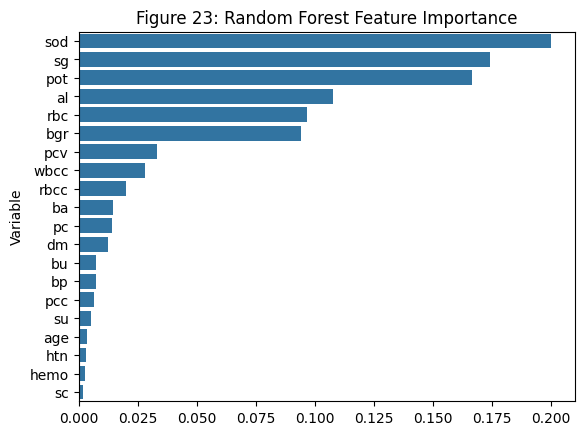

In [99]:
feature_importances = rfc.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

ax = sns.barplot(x=sorted_importances, y=sorted_feature_names)
ax.set(ylabel='Variable',
       title='Figure 23: Random Forest Feature Importance')
plt.show()

"sod" and "sg" are the most important features for this model, followed by "pot", "al" and "rbc". 

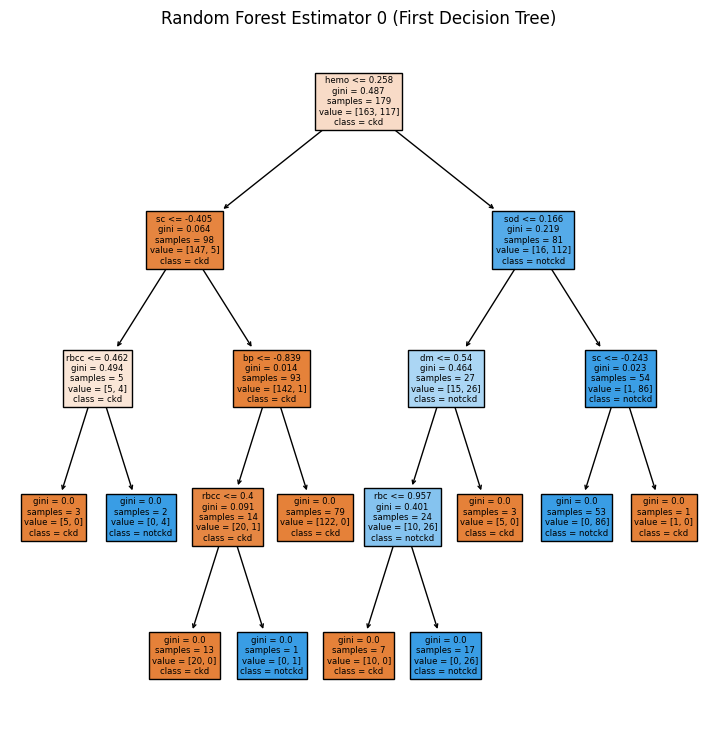

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

plot_tree(rfc.estimators_[0],
          feature_names = X.columns[data_feature_selector.support_].tolist(),
          class_names = y['class'].unique().tolist(),
          filled=True)
ax.set(title='Random Forest Estimator 0 (First Decision Tree)')
plt.show()

### 16. https://github.com/oatmilk123/datsci-final-assignment